In [32]:
import sys
sys.path.append('../../Models')

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import seaborn as sns

from pylab import rcParams
from scipy.interpolate import interp1d
rcParams['figure.figsize'] = 10, 10

from RealNVP import *
from sklearn import datasets

In [40]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [41]:
device = "cpu"

In [42]:
# Only run once, then load saved model
# flow = train(datasets, max_epochs=10000)

In [43]:
# Load flow
path_model = "TrainedModels/flow.pth"
flow = RealNVP(tfm_layers=6, latent_dim=2, device=device).to(device)
# path_model = "TrainedModels/flow_mix.pth"
# flow = RealNVP(tfm_layers=6, latent_dim=2, device=device, distribution="mixture", num_modes=2).to(device)
flow.load_state_dict(torch.load(path_model))
flow.eval()

RealNVP(
  (block_scale): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Tanh()
  )
  (block_trans): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (net_trans): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_f

Text(0.5, 1.0, '$X = g(z)$')

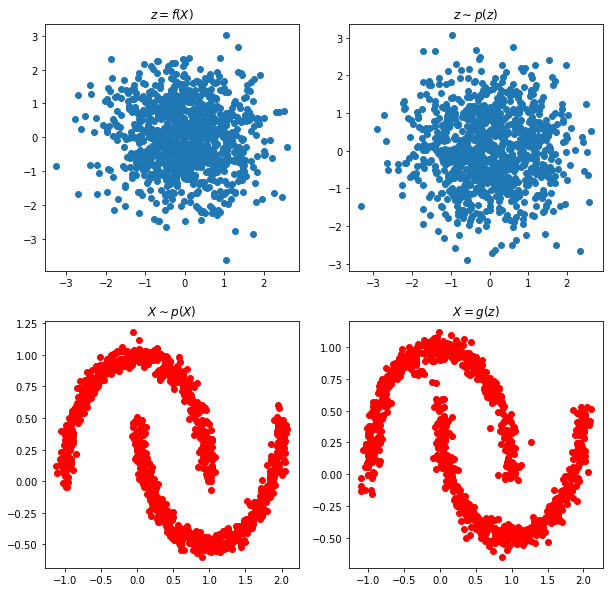

In [44]:
fig = plt.figure()
fig.patch.set_facecolor('w')

noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.to_latent(torch.from_numpy(noisy_moons).to(device))[0].cpu().detach().numpy()

plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000, False).detach().cpu().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## Streamplot

(250, 250) (250, 250) (250, 250) (250, 250)


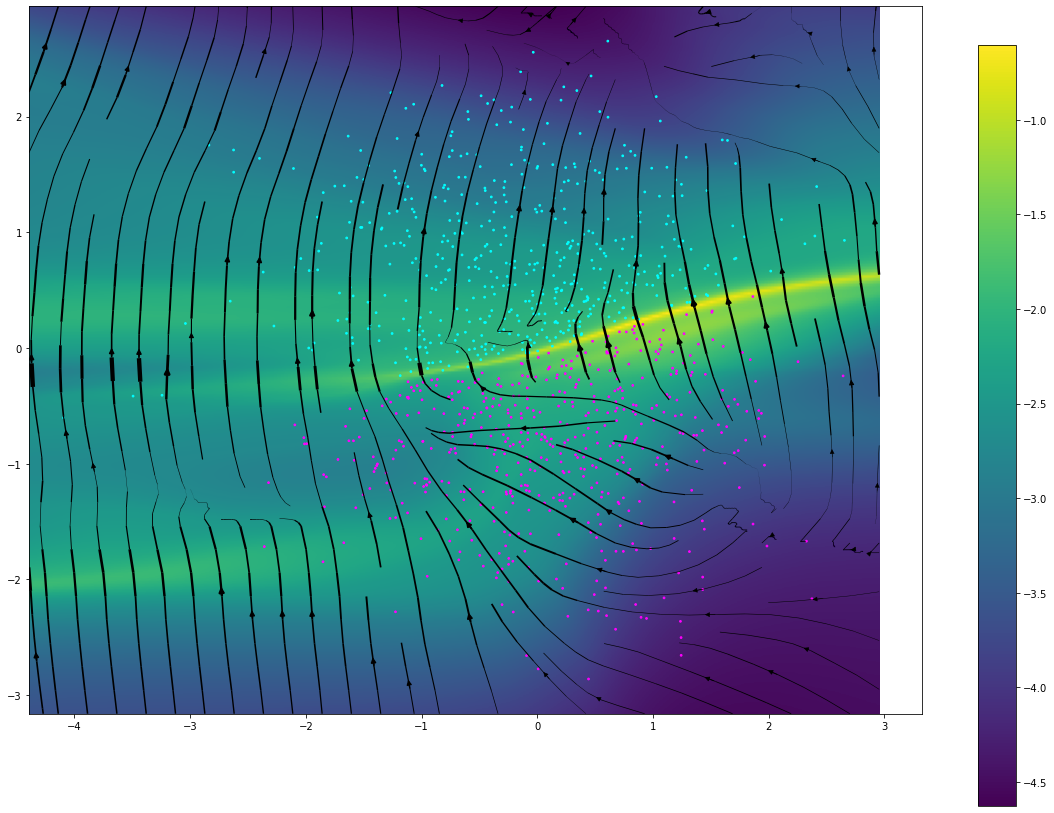

In [45]:
plt.close(fig)

fig = plt.figure(figsize=(20,20))
fig.patch.set_facecolor('w')

# First sample the dataset and outputs
x, y = datasets.make_moons(n_samples=1000, noise=.05)
x = x.astype(np.float32)
z = flow.to_latent(torch.from_numpy(x).to(device))[0].cpu().detach().numpy()

# Bounding box
x_x_min = x[:, 0].min() - 0.2
x_x_max = x[:, 0].max() + 0.2
x_y_min = x[:, 1].min() - 0.2
x_y_max = x[:, 1].max() + 0.2

z_x_min = z[:, 0].min() - 0.3
z_x_max = z[:, 0].max() + 0.3
z_y_min = z[:, 1].min() - 0.3
z_y_max = z[:, 1].max() + 0.3

steps = 250
z_xs = torch.linspace(z_x_min, z_x_max, steps=steps)
z_ys = torch.linspace(z_y_min, z_y_max, steps=steps)

z_xgrid, z_ygrid = torch.meshgrid(z_xs, z_ys, indexing='xy')
pts_grid = torch.hstack((z_xgrid.reshape(-1,1), z_ygrid.reshape(-1,1)))[:, None, :]
x_recon, log_det_j = flow.to_image(pts_grid.to(device), flag_condition=False)

# Background
log_det_j = log_det_j.detach().reshape(steps, steps)


jacob = flow.get_condition_number_to_image(torch.squeeze(pts_grid, axis=1))
eig_vals, eig_vecs = np.linalg.eigh(np.einsum("ijk,ijl->ikl", jacob, jacob))
cond_nums = np.abs(eig_vals.max(axis=1) / eig_vals.min(axis=1))

# Linewidth
cond_nums = cond_nums.reshape(steps, steps)
log_cond_nums = np.log(cond_nums)
log_cond_nums = 5 * log_cond_nums / log_cond_nums.max()

# Maximal for now:
u = eig_vecs[:, 1, 0].reshape(steps, steps)
v = eig_vecs[:, 1, 1].reshape(steps, steps)

print(z_xgrid.numpy().shape, z_ygrid.numpy().shape, u.shape, v.shape)
im = plt.imshow(log_det_j, origin="lower", extent=(z_x_min, z_x_max, z_y_min, z_y_max), cmap="viridis")
fig.colorbar(im, location='right', anchor=(0, 0.3), shrink=0.7)
plt.scatter(z[:, 0], z[:, 1], c=y, s=3, cmap="cool")
plt.streamplot(z_xgrid.numpy(), z_ygrid.numpy(), u, v, density=1., color='k', linewidth=log_cond_nums)

plt.savefig("Outputs/maximal_eigs", transparent=False)

(125, 125) (125, 125) (125, 125) (125, 125)


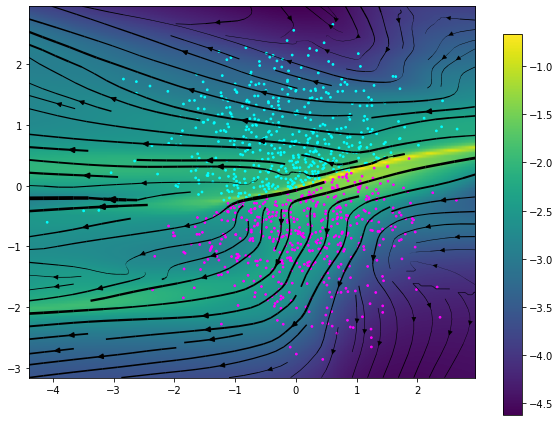

In [14]:
plt.close(fig)

fig = plt.figure()
fig.patch.set_facecolor('w')

# Maximal for now:
u = eig_vecs[:, 0, 0].reshape(steps, steps)
v = eig_vecs[:, 0, 1].reshape(steps, steps)

print(z_xgrid.numpy().shape, z_ygrid.numpy().shape, u.shape, v.shape)
im = plt.imshow(log_det_j, origin="lower", extent=(z_x_min, z_x_max, z_y_min, z_y_max), cmap="viridis")
fig.colorbar(im, location='right', anchor=(0, 0.3), shrink=0.7)
plt.scatter(z[:, 0], z[:, 1], c=y, s=3, cmap="cool")
plt.streamplot(z_xgrid.numpy(), z_ygrid.numpy(), u, v, density=1., color='k', linewidth=log_cond_nums)
plt.savefig("Outputs/minimal_eigs", transparent=False)

## Scratch

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [132]:
w = 3
Y, X = np.mgrid[-w:w:100j, -w:w:100j]
U = 1 + X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U**2 + V**2)

In [38]:
Y.shape, X.shape, U.shape, V.shape, speed.shape

((100, 100), (100, 100), (100, 100), (100, 100), (100, 100))

Text(0.5, 1.0, 'Varying Line Width')

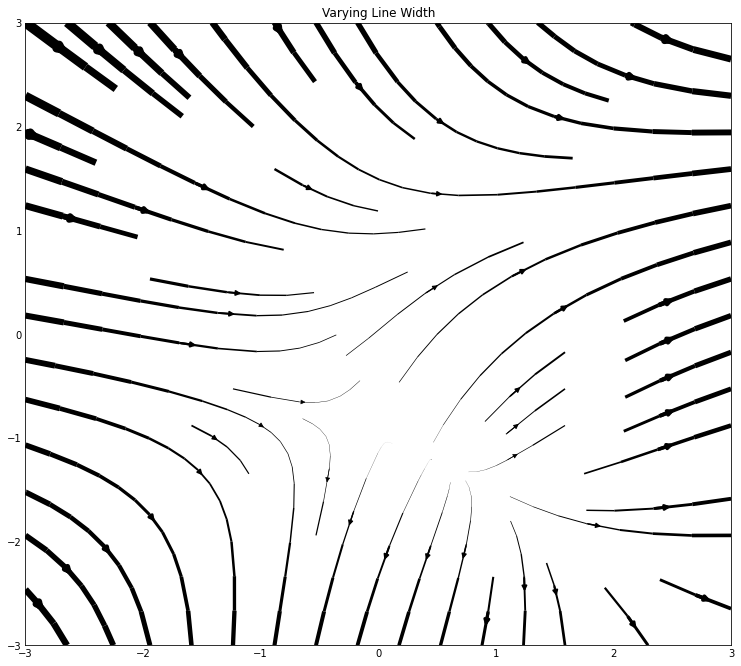

In [39]:
#  Varying line width along a streamline
fig = plt.figure(figsize=(10, 10))
lw = 10*speed / speed.max()
plt.streamplot(X, Y, U, V, density=0.6, color='k', linewidth=lw)
plt.title('Varying Line Width')

In [53]:
noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
loss = -flow(torch.from_numpy(noisy_moons).to(device))
loss.dtype

torch.float32